In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import shapely.geometry as geom

%matplotlib inline 
import matplotlib.pyplot as pyplot

## Read world city network data
This is dataset 11 from the site linked [here](links-6.qmd).

In [2]:
wcn = pd.read_csv('da11-1.csv', index_col=0)
wcn.head(5)

,Ernst & Young,Arthur Andersen,MSI,IGAF,AGN,BDO,Grant Thornton,Horwath,KPMG,Summit & Baker,...,Mercer,Boston,Deloitte,BoozeA&M,A.T. Kearney,McKinsey,Bain,Compass,Andersen Consulting,Gemini
name,,,,,,,,,,,,,,,,,,,,,
ABERDEEN,2,0,0,0,0,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
ABIJAN,3,0,0,0,0,0,0,0,2,0,...,0,0,2,0,0,0,0,0,0,0
ABU DHABI,2,2,0,0,2,0,0,2,2,0,...,0,0,2,2,0,0,0,0,2,0
ACCRA,0,0,0,0,0,0,2,0,2,0,...,0,0,2,0,0,0,0,0,0,0
ADDIS ABABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Make the data into a network

In [17]:
def cut_table_at(table, x):
    tbl = table.copy()
    tbl[tbl[:] < x] = 0
    tbl[tbl[:] > 0] = 1
    return tbl[list(tbl.sum(axis=1) > 0)]

def make_network_from_incidence_table(tbl):
    incidence_matrix = np.array(tbl)
    adj_matrix = incidence_matrix.dot(incidence_matrix.transpose())
    np.fill_diagonal(adj_matrix, 0)
    G = nx.Graph(adj_matrix)
    return nx.relabel_nodes(G, dict(zip(G.nodes(), list(tbl.index))))
    
Gnx = make_network_from_incidence_table(cut_table_at(wcn, 4))

Here we add geodetic coordinates to the nodes.

In [6]:
wcn_ll = pd.read_csv('wcn-cities-ll.csv', index_col=0)

for name in Gnx.nodes():
    lon = wcn_ll.loc[name]['LONGITUDE']
    lat = wcn_ll.loc[name]['LATITUDE']
    Gnx.nodes[name]['lat'] = lat
    Gnx.nodes[name]['lon'] = lon

# nx.readwrite.gml.write_gml(Gnx, 'wcn.gml')
# nx.graphml.write_graphml(Gnx, 'wcn.graphml')

## Code to geographically project the network
### Particularly to show edges as geodesics (i.e. great circle paths)

In [7]:
import math
R = 6378.137 #km

# Forward projection is distance and (initial) bearing 
# from lon0, lat0 to lon1, lat 1
# Use the Haversine formulae, see
# https://en.wikipedia.org/wiki/Haversine_formula
def get_distance(lon0, lat0, lon1, lat1):
    lon0 = math.radians(lon0)
    lon1 = math.radians(lon1)
    lat0 = math.radians(lat0)
    lat1 = math.radians(lat1)
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + \
        math.cos(lat0) * math.cos(lat1) * \
        math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    b = math.atan2(math.sin(dlon) * math.cos(lat1), math.cos(lat0) * 
                   math.sin(lat1) - math.sin(lat0) * math.cos(lat1) * 
                   math.cos(dlon))
    return R * c

In [8]:
def get_omerc_projstring(lon1, lat1, lon2, lat2):
     return \
        f"+proj=omerc +lat_1={lat1} +lon_1={lon1} +lat_2={lat2} +lon_2={lon2}"

## Make a dateline cut

In [9]:
dateline = geom.LineString([(180, y) for y in range(-90, 91, 1)])

def split_at_dateline(points): #, split=antimeridian):
    # make points into a series of LineStrings
    linestrings = [geom.LineString([p1, p2]) 
                   for p1, p2 in zip(points[:-1], points[1:])]
    lengths = [ls.length for ls in linestrings]
    intersections = [l > 270 for l in lengths]
    if True in intersections:
        idx = intersections.index(True)
        coords1 = points[:idx]
        coords2 = points[idx+1:]
        if len(coords1) > 1 and len(coords2) > 1:
            return geom.MultiLineString([coords1, coords2])
        elif len(coords1) == 1 and len(coords2) == 1:
            return geom.MultiPoint(points)
        else:
            if len(coords1) > len(coords2):
                return geom.LineString(coords1)
            else:
                return geom.LineString(coords2)
    else:
        return geom.LineString(points)

### Code to make dense geodesics

In [10]:
geodesics = [] # list of lon-lat pairs as LineStrings
dense_geodesics = [] # list of LineStrings along the geodesic
cut_geodesics = [] # list of the geodesics cut at the dateline

In [11]:
# the steps along the geodesic
step_length = 100 # km

# iterate over the edges
for e in Gnx.edges():
    p1 = geom.Point(Gnx.nodes[e[0]]['lon'], Gnx.nodes[e[0]]['lat'])
    p2 = geom.Point(Gnx.nodes[e[1]]['lon'], Gnx.nodes[e[1]]['lat'])
    geodesics.append(geom.LineString([p1, p2]))

    dist = get_distance(p1.x, p1.y, p2.x, p2.y)
    # determine the number of steps
    n_steps = math.ceil(dist / step_length) 
    
    # make a geodataframe of the geodesic
    gdf = gpd.GeoDataFrame(geometry = [p1, p2])
    gdf.crs = "+proj=longlat"
    
    # project it oblique mercator with the geodesic as the central meridian
    projstring = get_omerc_projstring(p1.x, p1.y, p2.x, p2.y)
    gdf = gdf.to_crs(projstring)
    # retrieve the points in the projected space
    p1 = gdf.loc[0]['geometry']
    p2 = gdf.loc[1]['geometry']
    # now step along them
    x_step = (p2.x - p1.x) / n_steps
    y_step = (p2.y - p1.y) / n_steps
    dense_geodesic = geom.LineString([
        (p1.x + x_step * i, p1.y + y_step * i) for i in range(n_steps + 1)]) 
    
    # make up the new geodataframe and project it back to 4326
    gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dense_geodesic))
    gdf.crs = projstring
    gdf = gdf.to_crs("+proj=longlat")

    # append the dense geodesic (uncut and cut) to the lists
    dense_geodesic = gdf.geometry[0].coords
    dense_geodesics.append(geom.LineString(dense_geodesic))
    cut_geodesic = split_at_dateline(dense_geodesic)
    cut_geodesics.append(cut_geodesic)

In [12]:
# Make up GDFs
geodesics_gdf = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(geodesics))
geodesics_gdf.crs = "+proj=longlat"

geodesics_dense_gdf = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(dense_geodesics))
geodesics_dense_gdf.crs = "+proj=longlat"

geodesics_cut_gdf = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(cut_geodesics))
geodesics_cut_gdf.crs = "+proj=longlat"

## Mollweide fail maps

In [13]:
moll = '+proj=moll'

globe = geom.Polygon(geom.LineString(
  [geom.Point(-180, y) for y in [_ / 10 for _ in range(-900, 901)]] + \
  [geom.Point( 180, y) for y in [_ / 10 for _ in range(900, -901, -1)]]))
globe_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries([globe]))
globe_gdf.crs = "+proj=longlat"

globe_m = globe_gdf.to_crs(moll)
countries = gpd.read_file("ne-world.gpkg")

(-19844105.265762024,
 19844105.265762024,
 -9922052.632687533,
 9922052.632687533)

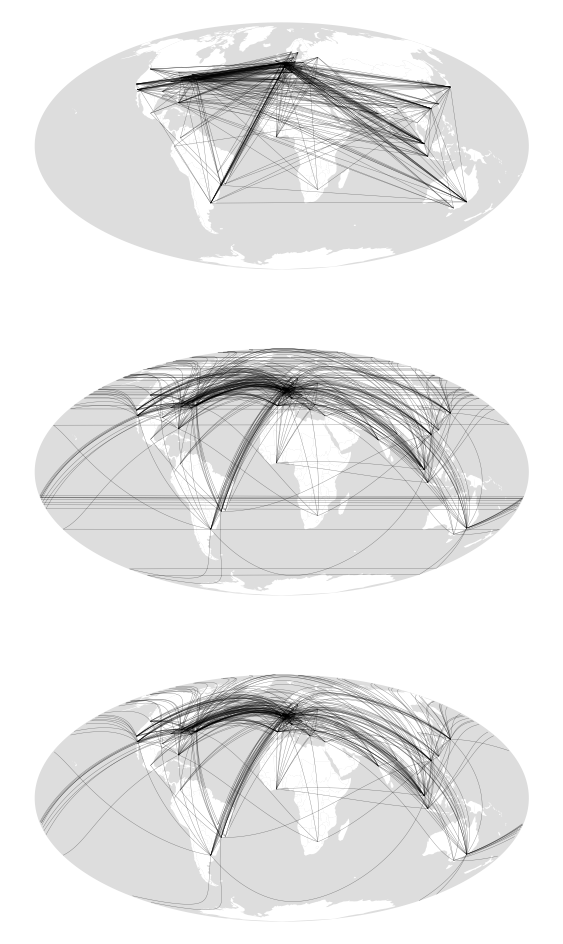

In [14]:
countries_m = countries.to_crs(moll)
geodesics_m1 = geodesics_gdf.to_crs(moll)
geodesics_m2 = geodesics_dense_gdf.to_crs(moll)
geodesics_m3 = geodesics_cut_gdf.to_crs(moll)

fig = pyplot.figure(figsize=(8, 12))

ax = fig.add_subplot(311)
globe_m.plot(ax=ax, fc = '#dddddd')
countries_m.plot(ax = ax, fc = 'w', linewidth = 0)
geodesics_m1.plot(ax = ax, color = 'k', alpha = 0.5, linewidth = 0.25)
pyplot.axis("off")

ax = fig.add_subplot(312)
globe_m.plot(ax = ax, fc = '#dddddd')
countries_m.plot(ax = ax, fc = 'w', linewidth = 0)
geodesics_m2.plot(ax = ax, color = 'k', alpha = 0.5, linewidth = 0.25)
pyplot.axis("off")

ax = fig.add_subplot(313)
globe_m.plot(ax = ax, fc = '#dddddd')
countries_m.plot(ax = ax, fc = 'w', linewidth = 0)
geodesics_m3.plot(ax = ax, color = 'k', alpha = 0.5, linewidth = 0.25)
pyplot.axis("off")

## Orthographic not so fail maps

(-7015950.7, 7015950.7, -6992427.545669697, 6992427.545669697)

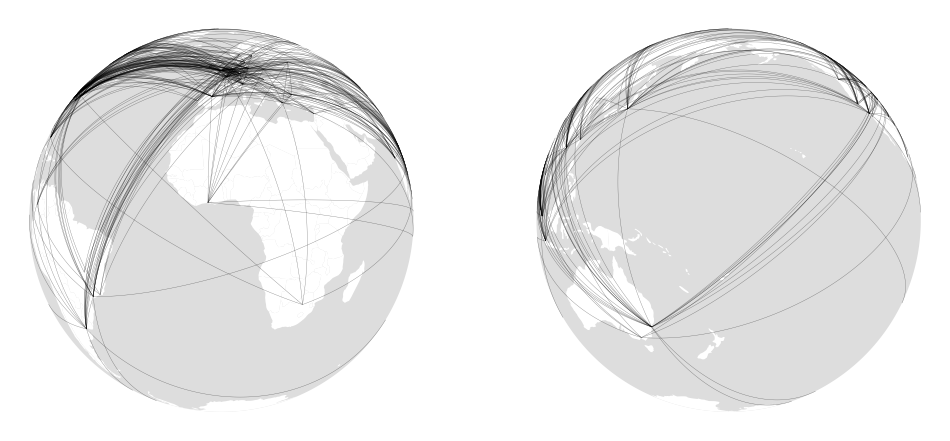

In [15]:
atlantic = '+proj=ortho +lon_0=0 +lat_0=0'
pacific = '+proj=ortho +lon_0=180 +lat_0=0'

globe_o = globe_gdf.copy()
globe_o.geometry = globe_o.scale(xfact = 0.5)
globe_o = globe_o.to_crs("+proj=ortho")
countries_a = gpd.read_file('front.gpkg').to_crs(atlantic)
countries_p = gpd.read_file('back.gpkg').to_crs(pacific)
geodesics_a = geodesics_dense_gdf.to_crs(atlantic)
geodesics_p = geodesics_dense_gdf.to_crs(pacific)

fig = pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(121)
globe_o.plot(ax = ax, fc = '#dddddd')
countries_a.plot(ax = ax, fc = 'w', linewidth = 0)
geodesics_a.plot(ax = ax, color = 'k', alpha = 0.5, linewidth = 0.25)
pyplot.axis("off")

ax = fig.add_subplot(122)
globe_o.plot(ax = ax, fc = '#dddddd')
countries_p.plot(ax = ax, fc = 'w', linewidth = 0)
geodesics_p.plot(ax = ax, color = 'k', alpha = 0.5, linewidth = 0.25)
pyplot.axis("off")